# **Pairing Averaged**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import Materials_Parameters as mp
from MTI_Discretization import eigenstates_Dirichlet as eigenstates
from MTI_Second_Order import FMTI2_NeumannBC, Change_Basis, Block_Reverse

# parameters
d = 100.; mu = 0.010; Delta = 0.005
# coupling matrices
Gamma = np.matrix([[1,0],[0,1],[1,0],[0,1]])

plt.style.use(['default', './paper.mplstyle'])

## **Energy Spectrum**

In [2]:
# lattice
Nlat = 100; d = 100.; dZ = d/(Nlat-1)

egval = []; spinors = []
momentum = np.linspace(-0.15, 0.15, 201)

for k in momentum:

    # eigenstates
    lattice, egv, wf = eigenstates(Nlat=Nlat, dZ=dZ, kx = k, ky = 0., L = 0.)

    # indices for sorting by absolute value
    idx_sort = np.argsort(egv)
    # sort egval accordingly
    egv = egv[idx_sort]
    # sort wf accordingly
    wf = wf[idx_sort, :, :]   
    
    egval.append(egv); spinors.append(wf) 


egval = np.array(egval)
spinors = np.array(spinors)

print(egval.shape, spinors[0].shape)

(201, 400) (400, 100, 4)


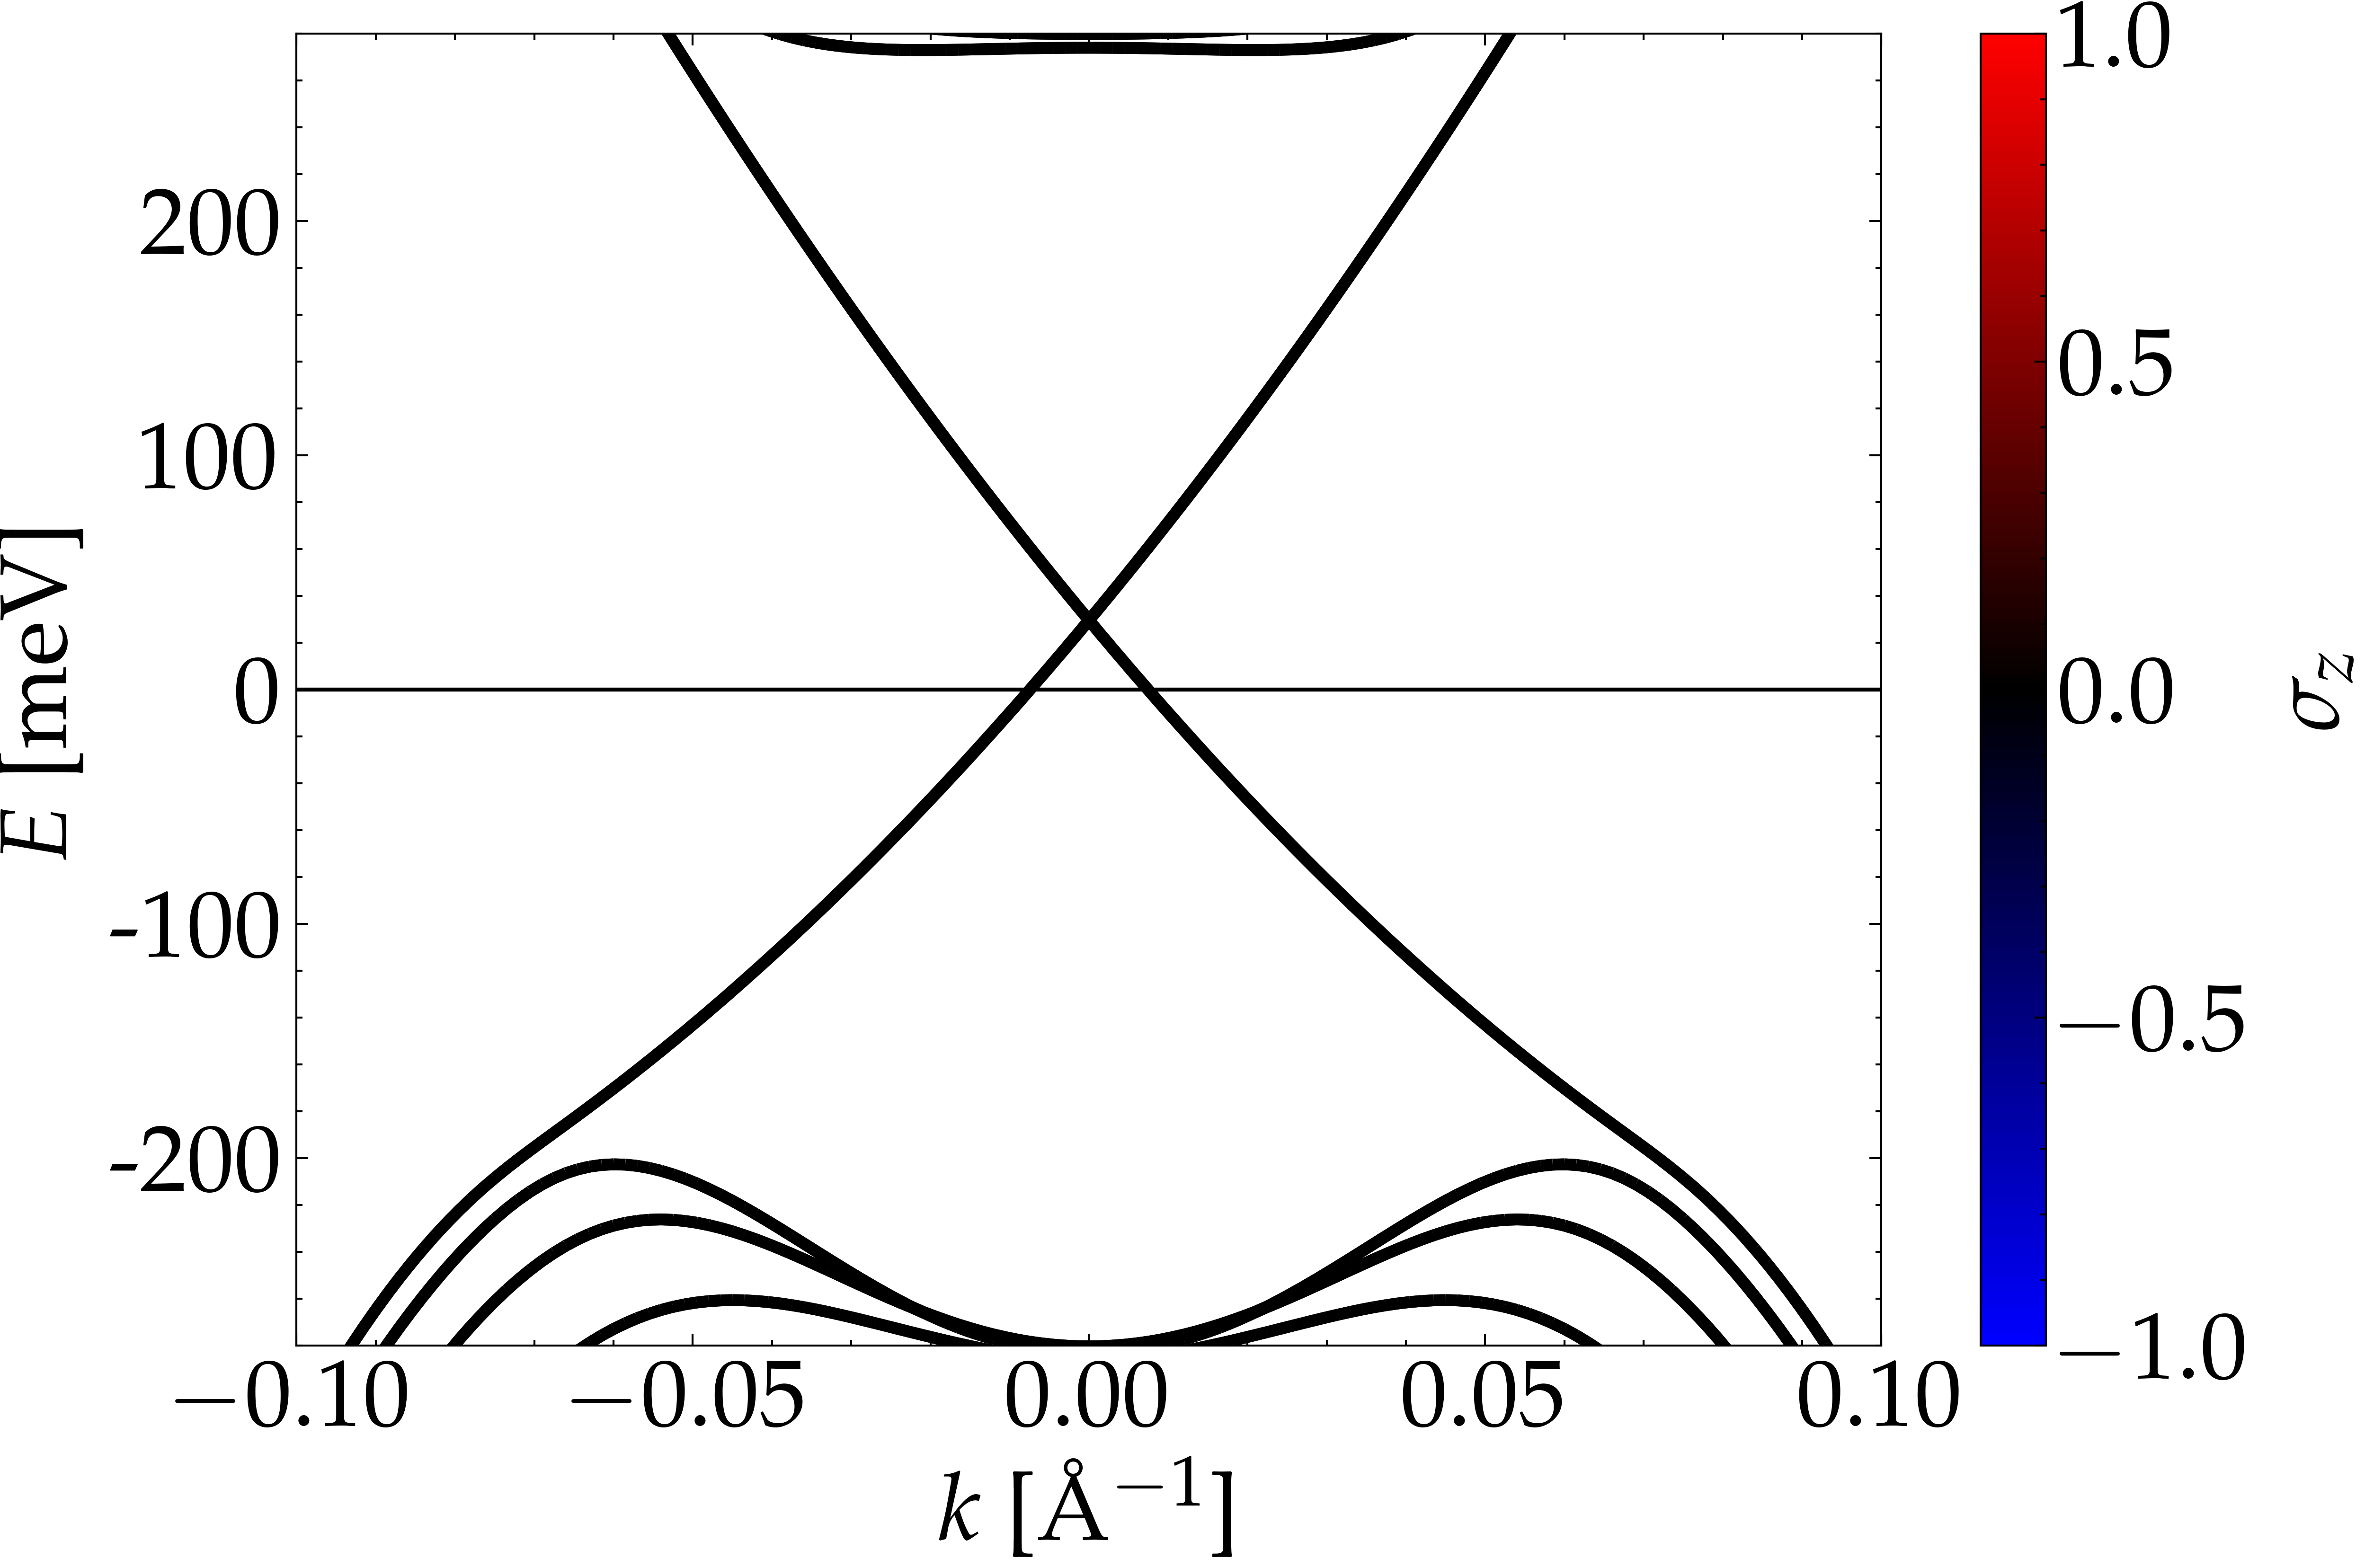

In [3]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap with wide black region
colors = [
    (0.0, (0, 0, 1)),   # blue at left
    (0.5, (0, 0, 0)),   # black starts early
    (0.5, (0, 0, 0)),   # black ends late
    (1.0, (1, 0, 0))    # red at right
]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("blue_wideblack_red", colors, N=256)

# figure
fig, ax = plt.subplots(1,1, figsize=(9,6))
# horizontal line zero energy
ax.axhline(0, ls='-', lw=1, c='black')

# number of k values
k_dim = spinors.shape[0]
# normalize between -1 and 1
norm = Normalize(vmin=-1, vmax=1)

# Sz operator in orbital x spin basis
Sz = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))


n = 50
for idx in range(n):
    
    # eigenstate index
    iegv = 200 - int(n/2) + idx 

    # get spin z for colors
    spin_z = [np.sum([np.vdot(s, Sz @ s).real for s in spinors[kdx,iegv]]) for kdx in range(k_dim)]
    spin_z = np.zeros(k_dim)
    
    # define x and y arrays for plot
    x,y = momentum, egval[:,iegv]
    
    # create line segments between consecutive points
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # create LineCollection
    lc = LineCollection(segments, cmap=cmap, array=spin_z[:-1], lw=3, norm=norm)

    # plot line
    line = ax.add_collection(lc)

cbar = fig.colorbar(line, ax=ax)

cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=24) 
cbar.set_label(r"$\sigma_z$", fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.set_xlabel('$k$ [Å$^{-1}$]', fontsize=24)
ax.set_ylabel('$E$ [meV]', fontsize=24)

ax.set_xlim(-0.1,0.1);
ax.set_ylim(-0.28,0.28);

ax.set_yticks([-0.2, -0.1, 0., 0.1, 0.2])
ax.set_yticklabels(['-200', '-100', '0', '100', '200']);

#fig.savefig('Paper/spectrum_0.svg', bbox_inches='tight', pad_inches=0.1)

## **Induced Pairing**

In [5]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("Pairing/pairing_L-0.txt")

# store data in matrices
F_data = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_data[idx][jdx] = Change_Basis(matrix)

print(F_data.shape)

(100, 100, 4, 4)


In [6]:
from MTI_Analytical import parameters

L = 0.0
# get decay length for electron and hole
lup, l2, g1, g2 = parameters(spin='up', L=L, omega=0)
ldw, l2, g1, g2 = parameters(spin='down', L=L, omega=0)

# evaluate pairing decay length 
xi = 1./(lup.real + ldw.real); print('decay length = ' + str(xi))

zlattice = np.linspace(0, 30., 100)/xi
#print(zlattice)

decay length = 4.521610020659315


### **Spin Components**

In [7]:
# swap spin only
F_swap = np.array([[Block_Reverse(f) for f in F1] for F1 in F_data])

# matrices for signlet
F_odd = 0.5*(F_data - F_swap)
# matrices for triplet
F_even = 0.5*(F_data + F_swap)


# spin singlet S=0 part
Fs_0 = np.sqrt(2)*F_odd[:, :, 0:2, 2:4]; fs_0 = np.linalg.norm(Fs_0, axis=(2, 3))

# spin triplet S=0 part
Ft_0 = np.sqrt(2)*F_even[:, :, 0:2, 2:4]; ft_0 = np.linalg.norm(Ft_0, axis=(2, 3))
# spin triplet S=1 part
Ft_p1 = F_even[:, :, 0:2, 0:2]; ft_p1 = np.linalg.norm(Ft_p1, axis=(2, 3))
# spin triplet S=-1 part
Ft_m1 = F_even[:, :, 2:4, 2:4]; ft_m1 = np.linalg.norm(Ft_m1, axis=(2, 3))


# total singlet component
fs = fs_0
# total triplet component
ft = np.sqrt( ft_0*ft_0 + ft_p1*ft_p1 + ft_m1*ft_m1  )

# normalize 
norm = np.max(fs+ft)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


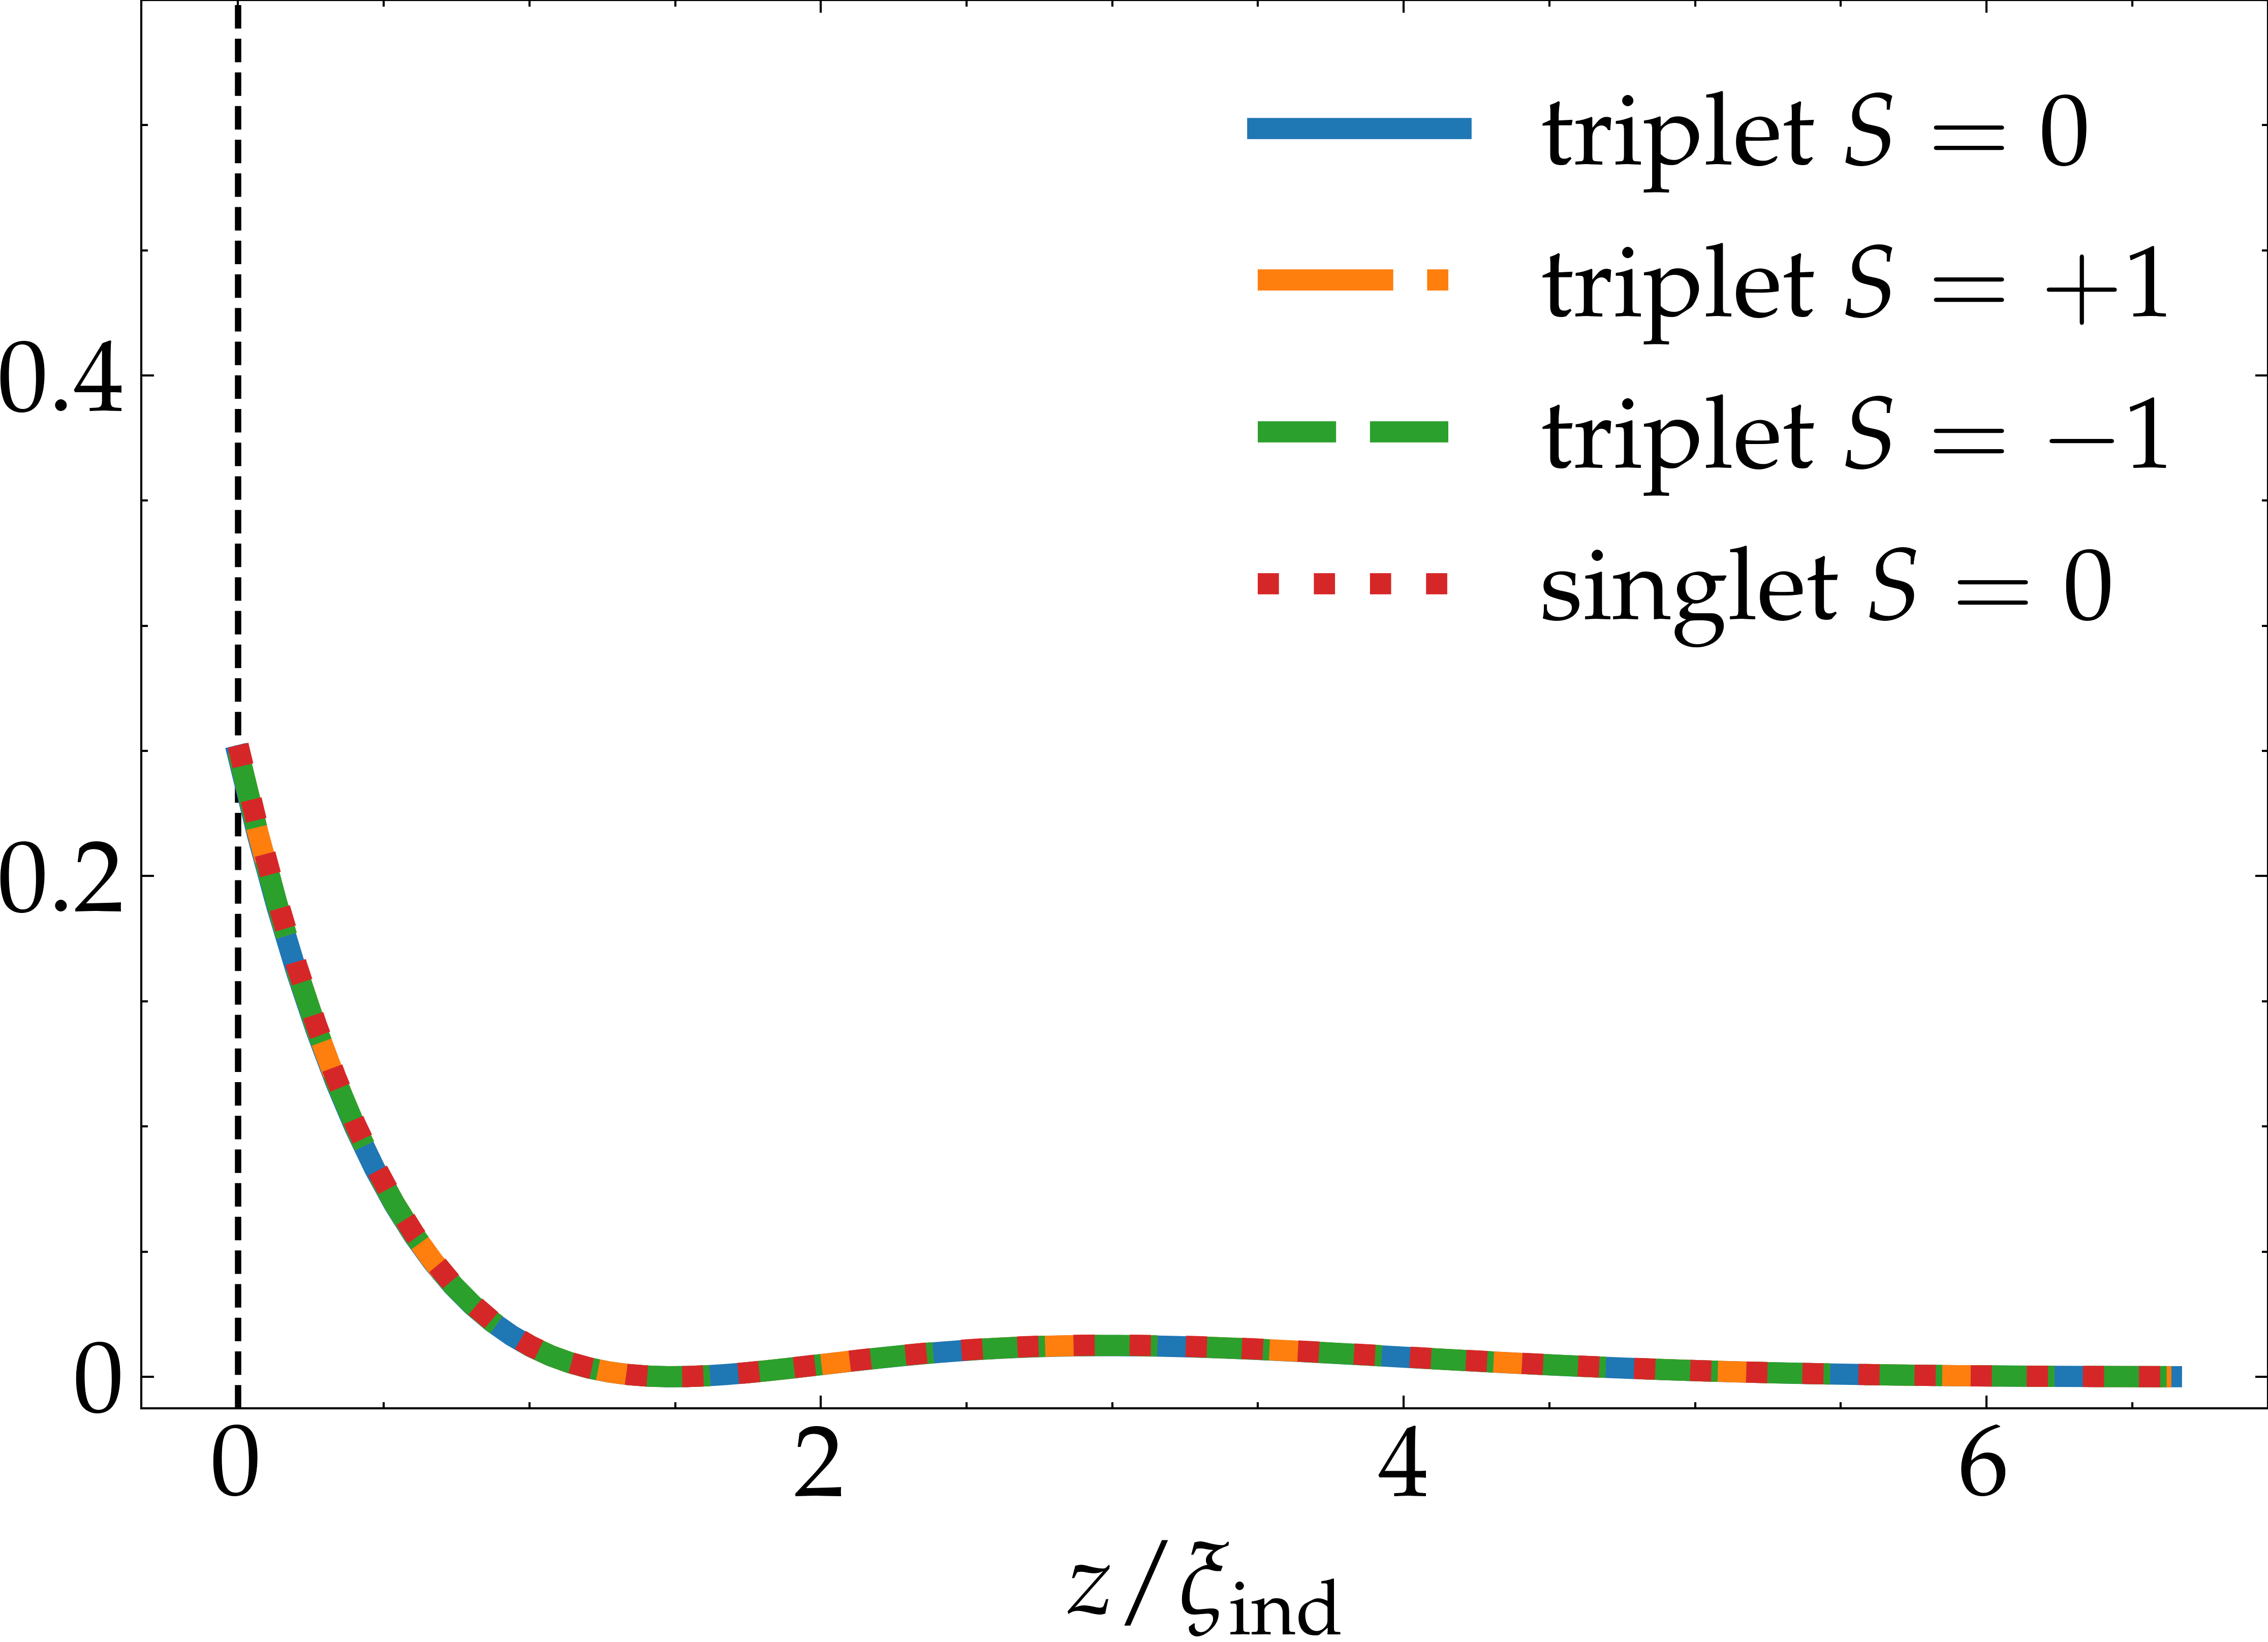

In [8]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

norm = np.sum(ft_0+ft_p1+ft_m1+fs_0, axis=0)[0]

# line at the MTI-SC interface
ax.axvline(x=0, c='black', ls='dashed', lw=1.5)

# triplet components
ax.plot(zlattice, np.sum(ft_0, axis=0)/norm, lw=5, label='triplet $S=0$')
ax.plot(zlattice, np.sum(ft_p1, axis=0)/norm, lw=5, label='triplet $S=+1$', ls='-.')
ax.plot(zlattice, np.sum(ft_m1, axis=0)/norm, lw=5, label='triplet $S=-1$', ls='--')
# singlet component
ax.plot(zlattice, np.sum(fs_0, axis=0)/norm, lw=5, label='singlet $S=0$', ls=':') #ls=':')

ax.set_xlabel("$z / \\xi_{\mathrm{ind}}$", fontsize = 24)

ax.set_ylim(ax.get_ylim()[0], 0.55)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels(['0', '0.2', '0.4'])

ax.tick_params(axis='both', which='major', labelsize=24)

ax.legend(fontsize=24);

#plt.savefig('Paper/spin_0.svg', bbox_inches='tight', pad_inches=0.1)

### **Momentum Components**

In [9]:
# reverse momentum
F_krev = F_data[::-1, :, :, :]

# matrices for even components
F_even = 0.5*(F_data + F_krev)
# matrices for odd components
F_odd = 0.5*(F_data - F_krev)

fe = np.linalg.norm(F_even, axis=(2, 3))
fo = np.linalg.norm(F_odd, axis=(2, 3))
norm = np.max(fe+fo)

print(fs.shape, ft.shape)

(100, 100) (100, 100)


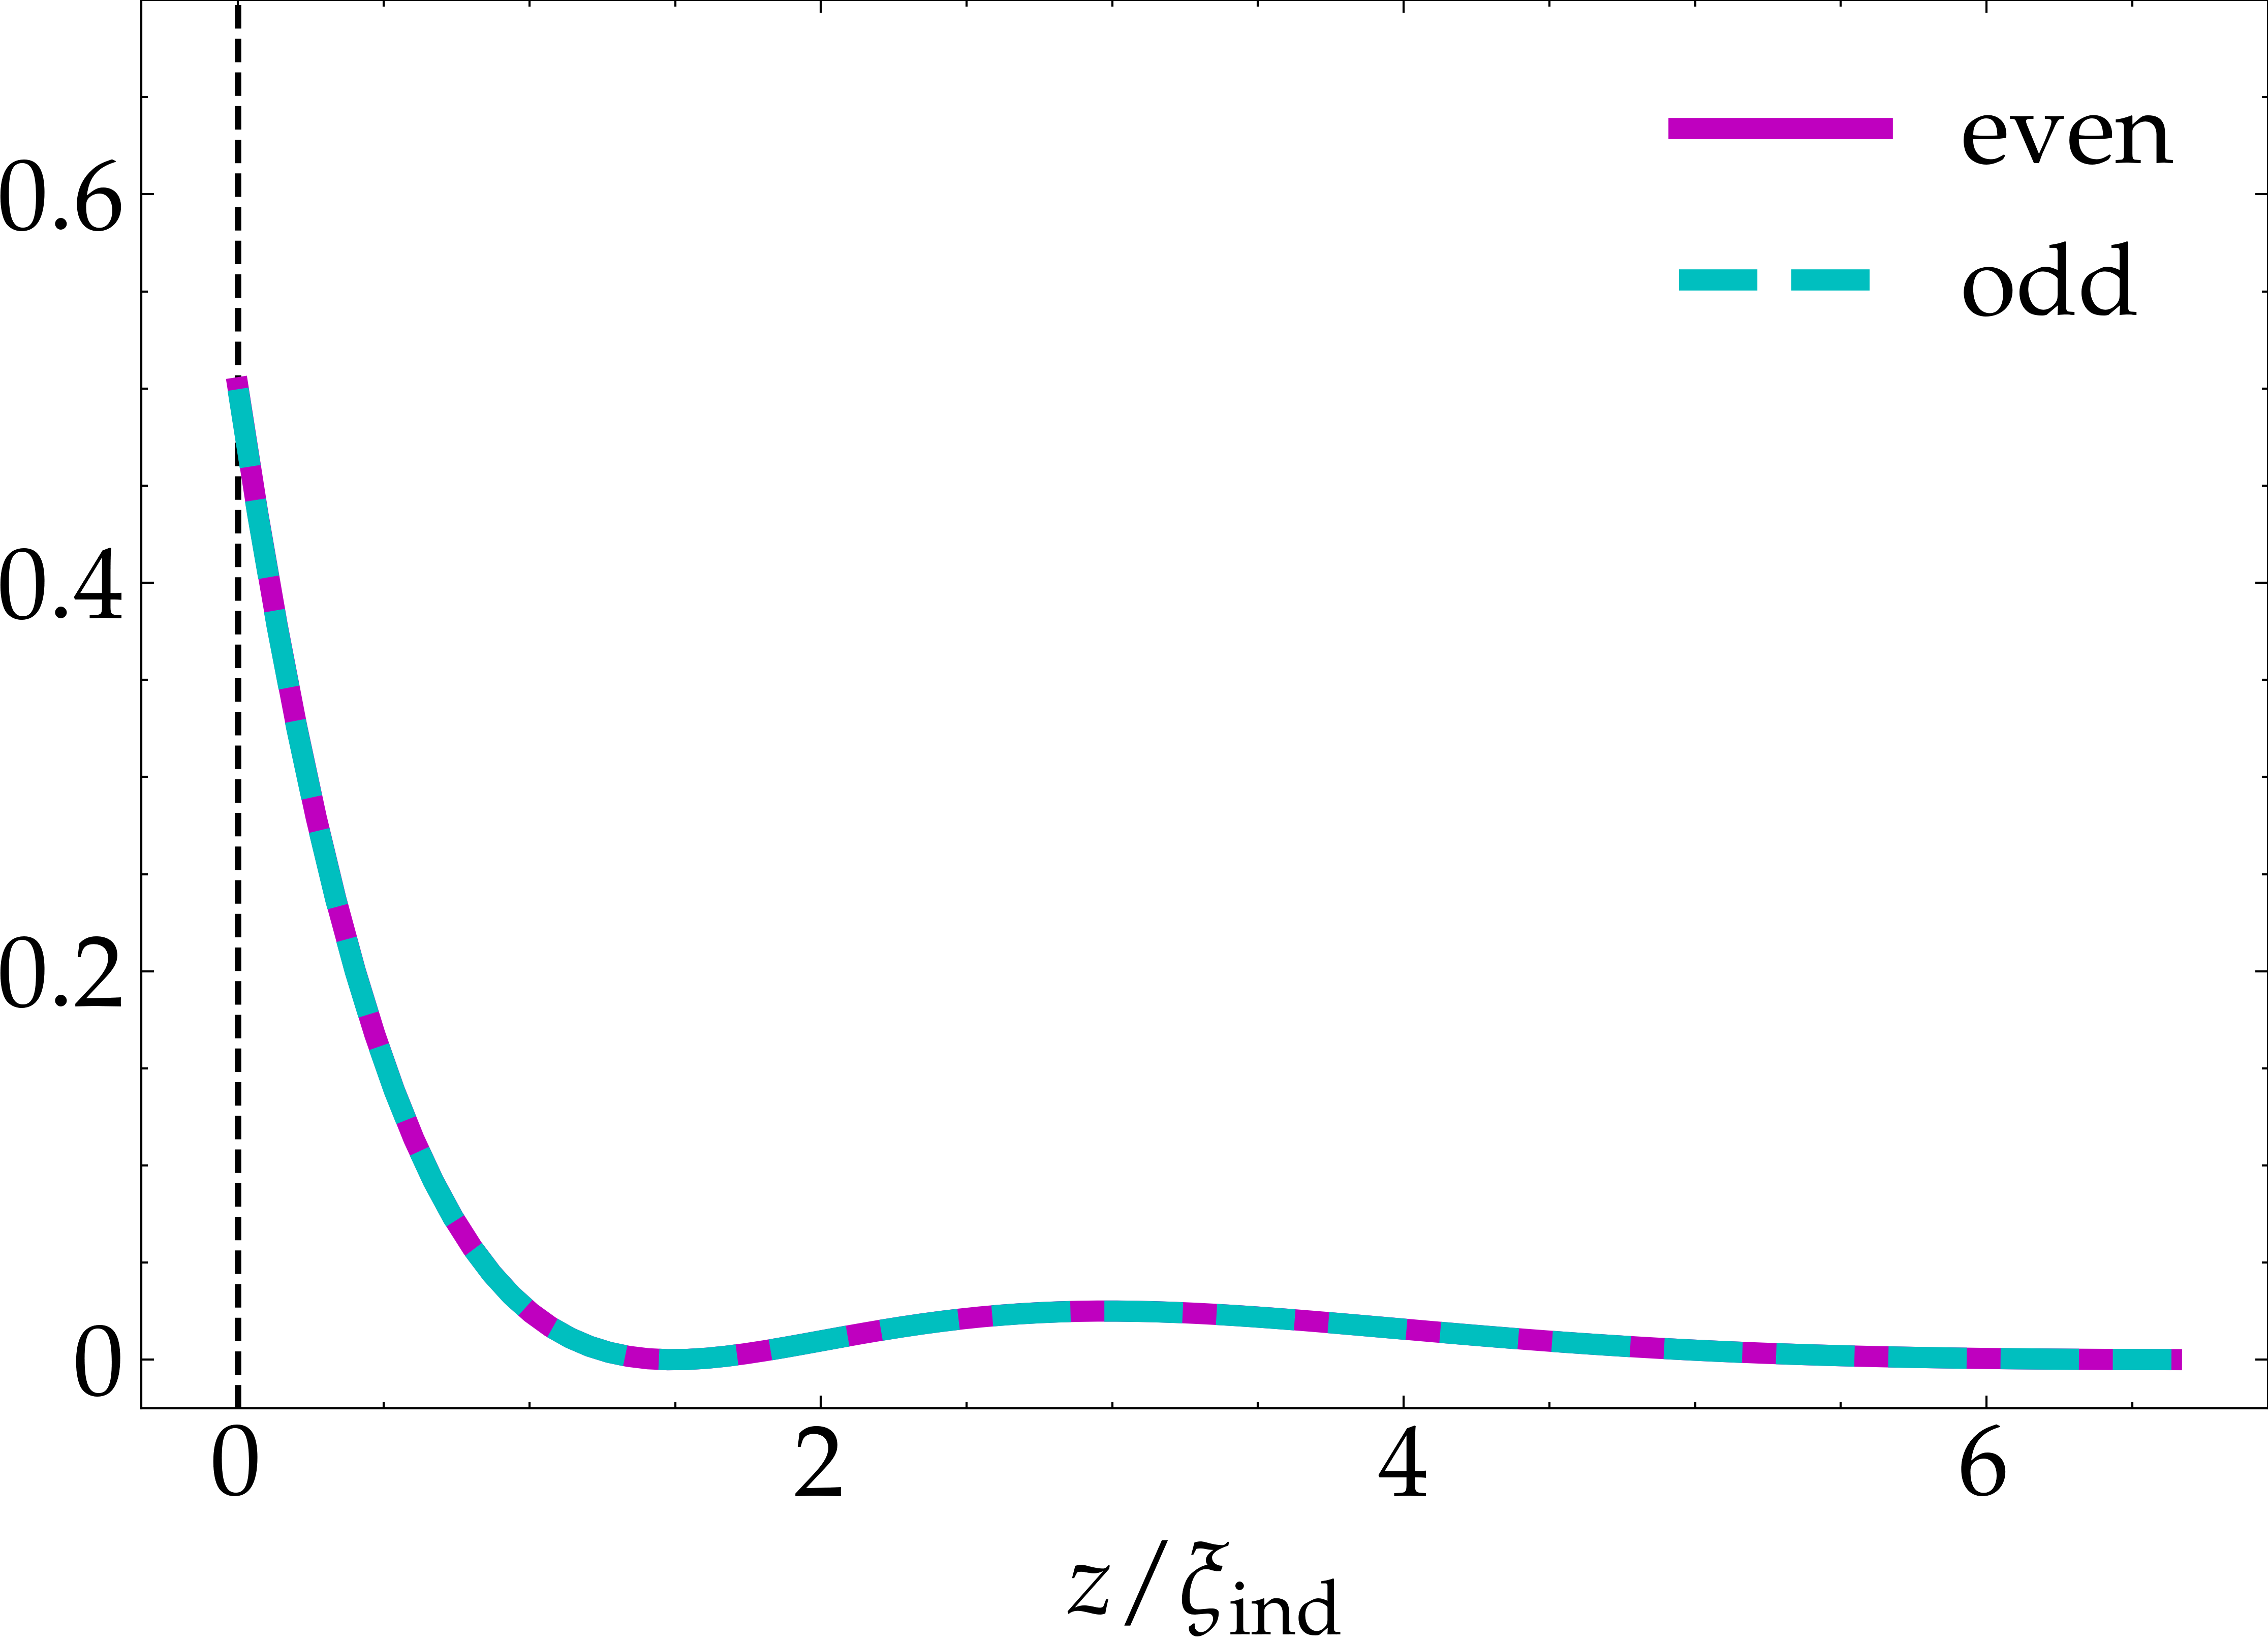

In [10]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

norm = np.sum(fe+fo, axis=0)[0]

ax.axvline(x=0, c='black', ls='dashed', lw=1.5)

ax.plot(zlattice, np.sum(fe, axis=0)/norm, lw=5, label='even', c='m')
ax.plot(zlattice, np.sum(fo, axis=0)/norm, lw=5, label='odd', c='c', ls='--')


ax.set_xlabel("$z / \\xi_{\mathrm{ind}}$", fontsize = 24)

ax.set_ylim(ax.get_ylim()[0], 0.7)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6'])

ax.tick_params(axis='both', which='major', labelsize=24)

ax.legend(fontsize=24);

#plt.savefig('Paper/parity_0.svg', bbox_inches='tight', pad_inches=0.1)

## **Effective Model**

In [11]:
# shape of the matrix 
n = 4
# space dimensions
K = []; k_dim = 100

# Zeeman values
Zeeman = np.round(np.arange(-0.050, 0.050 + 0.0005, 0.0005), 4)
# store data in matrices
F_model = np.empty((Zeeman.shape[0], k_dim, 4, 4), dtype='complex')


# loop over all files with various Zeeman
for idx, L in enumerate(Zeeman):

    # select file
    filename = "Pairing/Zeeman_kx/pairing_" + str(round(L*1000,3)) + ".txt"
    
    # read file pairing
    rows = np.loadtxt(filename)

    # loop over momenta
    for jdx in range(k_dim):
                
        # read one row
        row = rows[jdx]

        if jdx == 0: K.append(float(row[0]))
    
        # real part
        real = row[1 : 1 + n*n].reshape((n, n))
        # imaginary part
        imag = row[1 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_model[idx][jdx] = Change_Basis(matrix)

print(F_model.shape)

(201, 100, 4, 4)


In [12]:
from Pairing_Effective_Model import Project_All

c_proj = np.empty(F_model.shape, dtype='complex')

# loop over Zeeman
for idx in range(F_model.shape[0]):
    # loop over momentum 
    for jdx in range(F_model.shape[1]):

        # get the pairing for given k,z
        F = F_model[idx, jdx]
        # project over matrices
        c_proj[idx,jdx] = Project_All(F, normalize=False)


# get the modulus squared
c_weights = np.abs(c_proj)**2
#c_weights = c_proj
# average over k 
C_weights = np.sum(c_weights, axis=1)

# get the phase of the coefficients
c_phase = np.angle(c_proj)
# average over k 
C_phase = np.average(c_phase, axis=1)

### **Absolute Values**

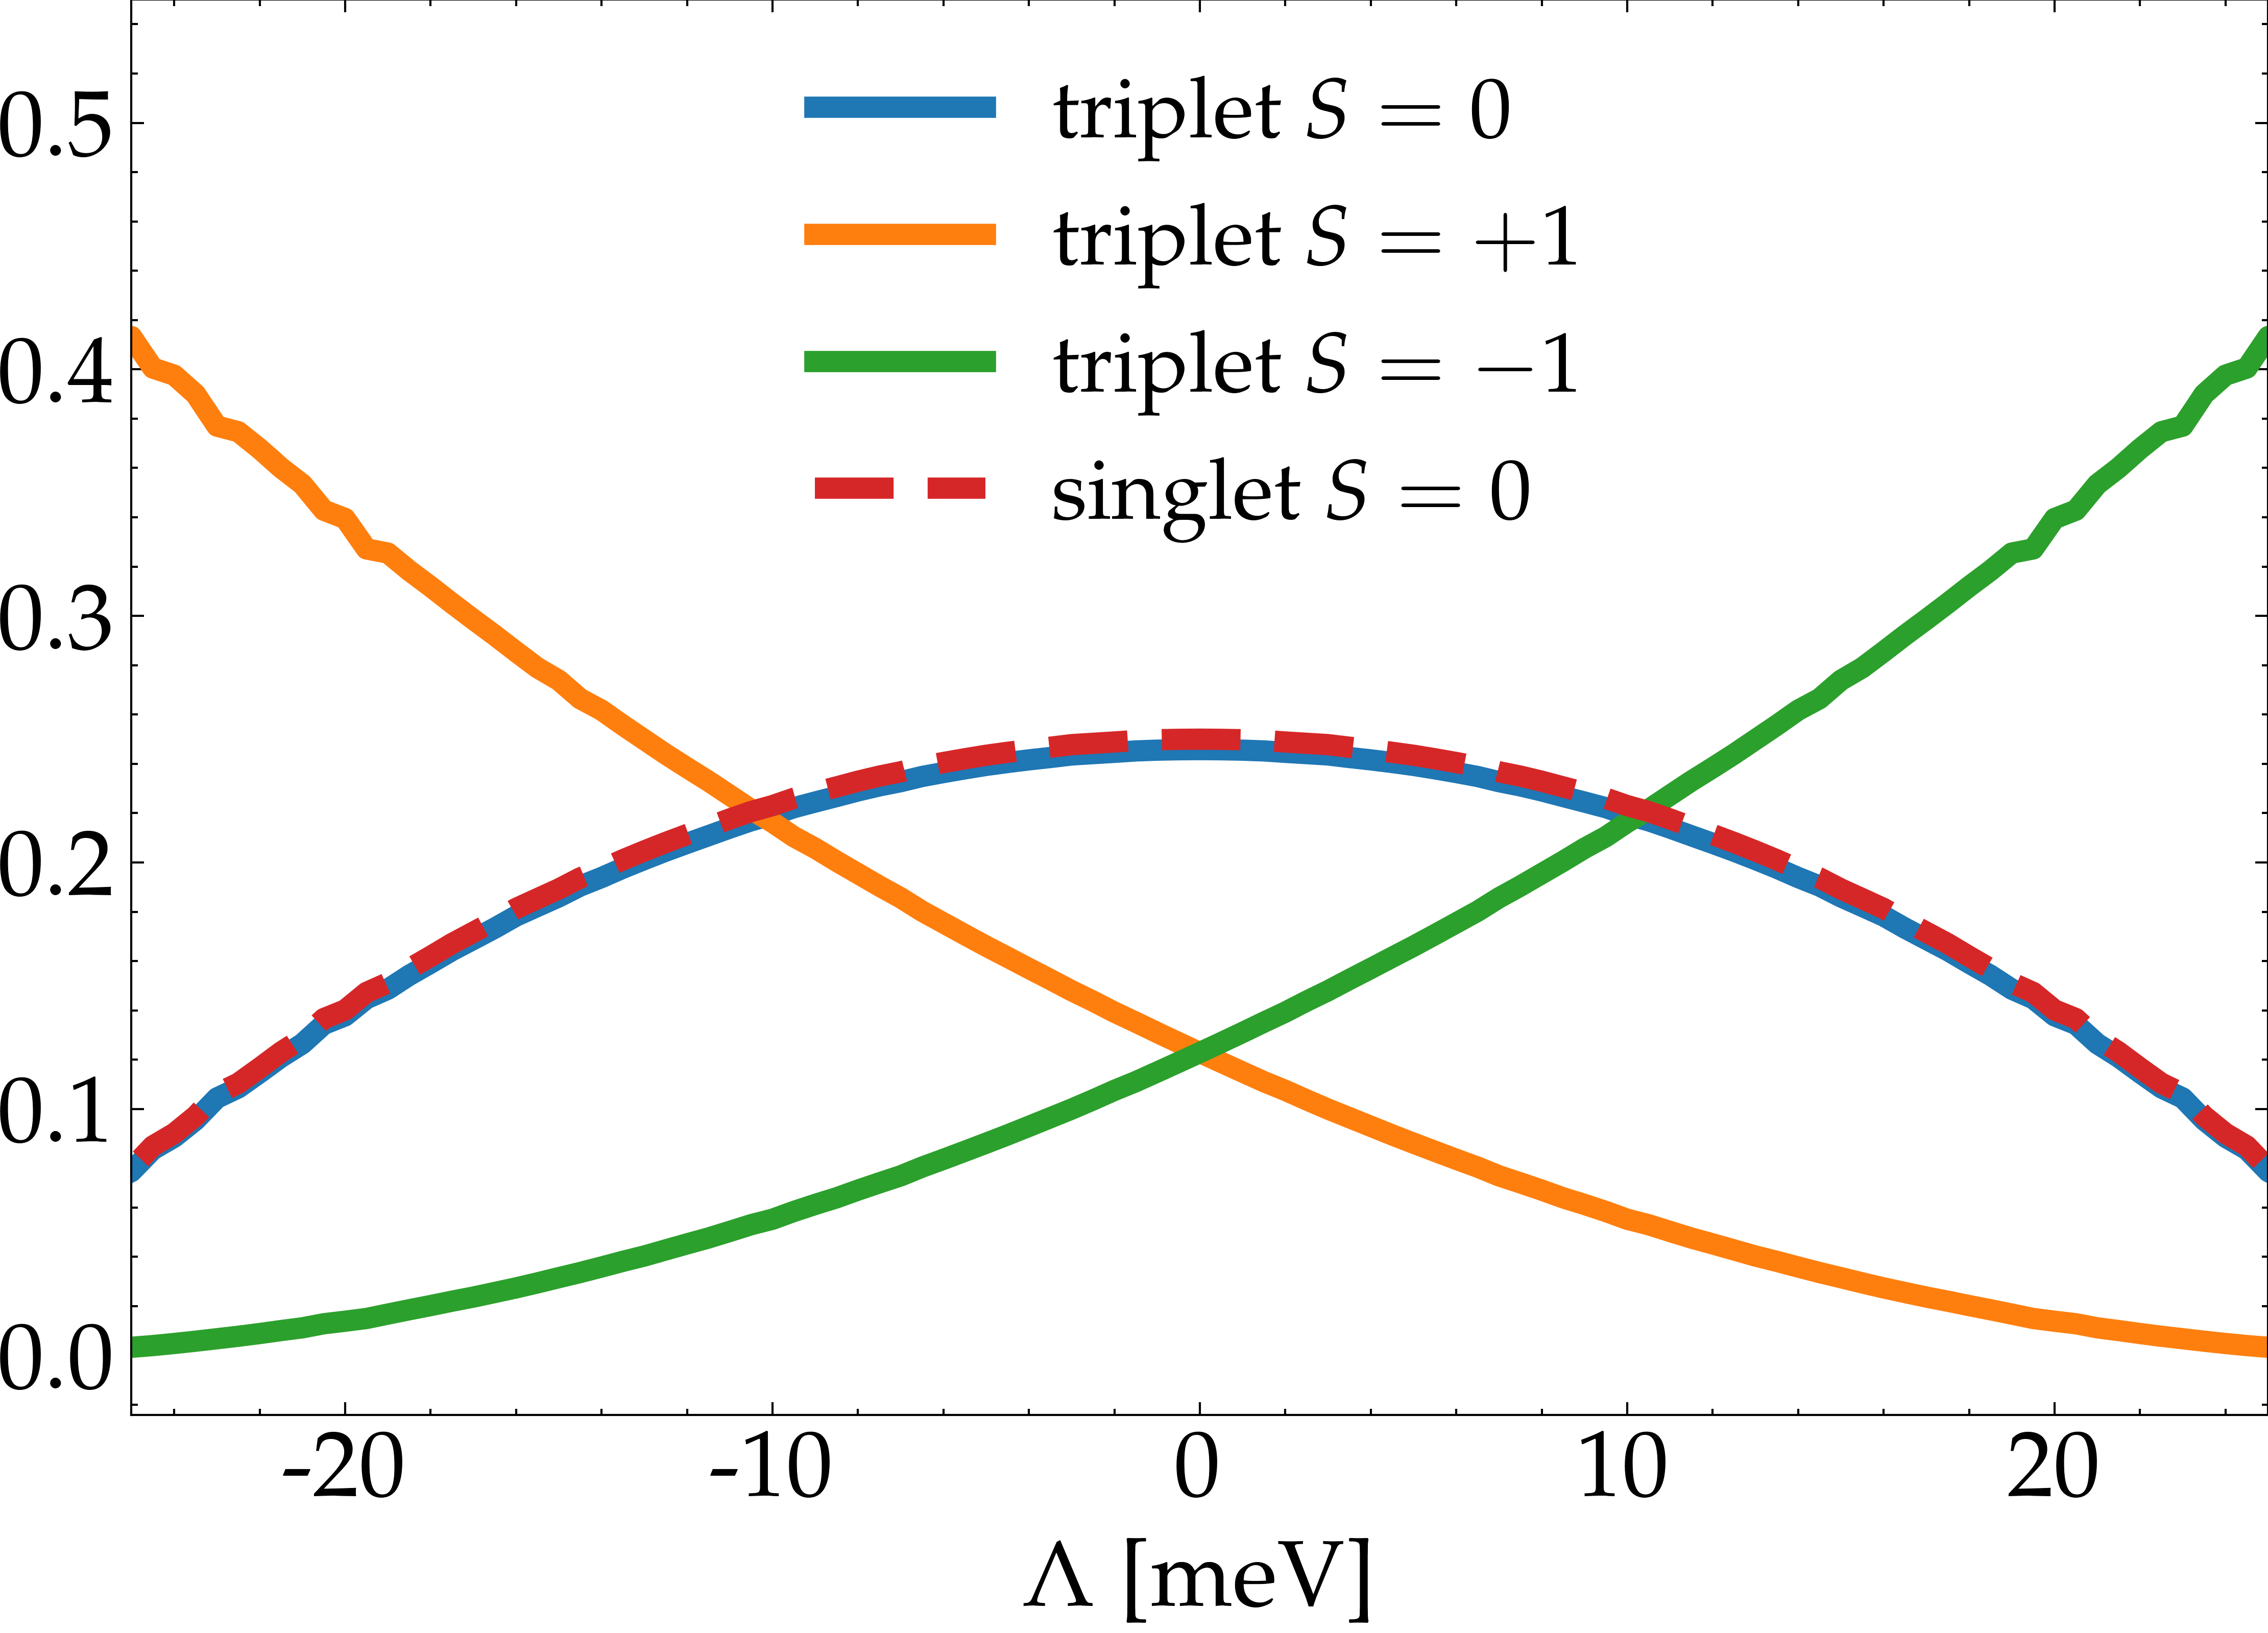

In [13]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

labels = ['triplet $S=0$',
          'triplet $S=+1$',
          'triplet $S=-1$',
          'singlet $S=0$']

ls = ['-', '-', '-', '--']

# normalization
norm = np.sum(C_weights, axis=(1,2))

for idx, spin, orbital in zip(range(4), [1,2,3,0], [2, 1, 1, 0]):

    # plot the coefficients
    ax.plot(Zeeman, C_weights[:, spin, orbital]/norm , lw=5, label=labels[idx], ls=ls[idx])




ax.set_xlabel("$\Lambda$ [meV]", fontsize = 22)
ax.set_xlim(-0.025, 0.025)
ax.set_xticks([-0.020, -0.010, 0, 0.010, 0.020])
ax.set_xticklabels(['-20', '-10', '0', '10', '20'])

ax.set_ylim(ax.get_ylim()[0], 0.55)
#ax.set_yticks([0, 0.25, 0.5])
#ax.set_yticklabels(['0', '0.25', '0.5'])

ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=20);

#plt.savefig('Paper/effective_model.pdf', bbox_inches='tight', pad_inches=0.1)

### **Singlet/Triplet Components**

In [14]:
# swap spin only
F_swap = np.array([[Block_Reverse(f) for f in F1] for F1 in F_model])

# matrices for signlet
F_odd = 0.5*(F_model - F_swap)
# matrices for triplet
F_even = 0.5*(F_model + F_swap)


# spin singlet S=0 part
Fs_0 = np.sqrt(2)*F_odd[:, :, 0:2, 2:4]; fs_0 = np.linalg.norm(Fs_0, axis=(2, 3))

# spin triplet S=0 part
Ft_0 = np.sqrt(2)*F_even[:, :, 0:2, 2:4]; ft_0 = np.linalg.norm(Ft_0, axis=(2, 3))
# spin triplet S=1 part
Ft_p1 = F_even[:, :, 0:2, 0:2]; ft_p1 = np.linalg.norm(Ft_p1, axis=(2, 3))
# spin triplet S=-1 part
Ft_m1 = F_even[:, :, 2:4, 2:4]; ft_m1 = np.linalg.norm(Ft_m1, axis=(2, 3))

print(fs_0.shape)

(201, 100)


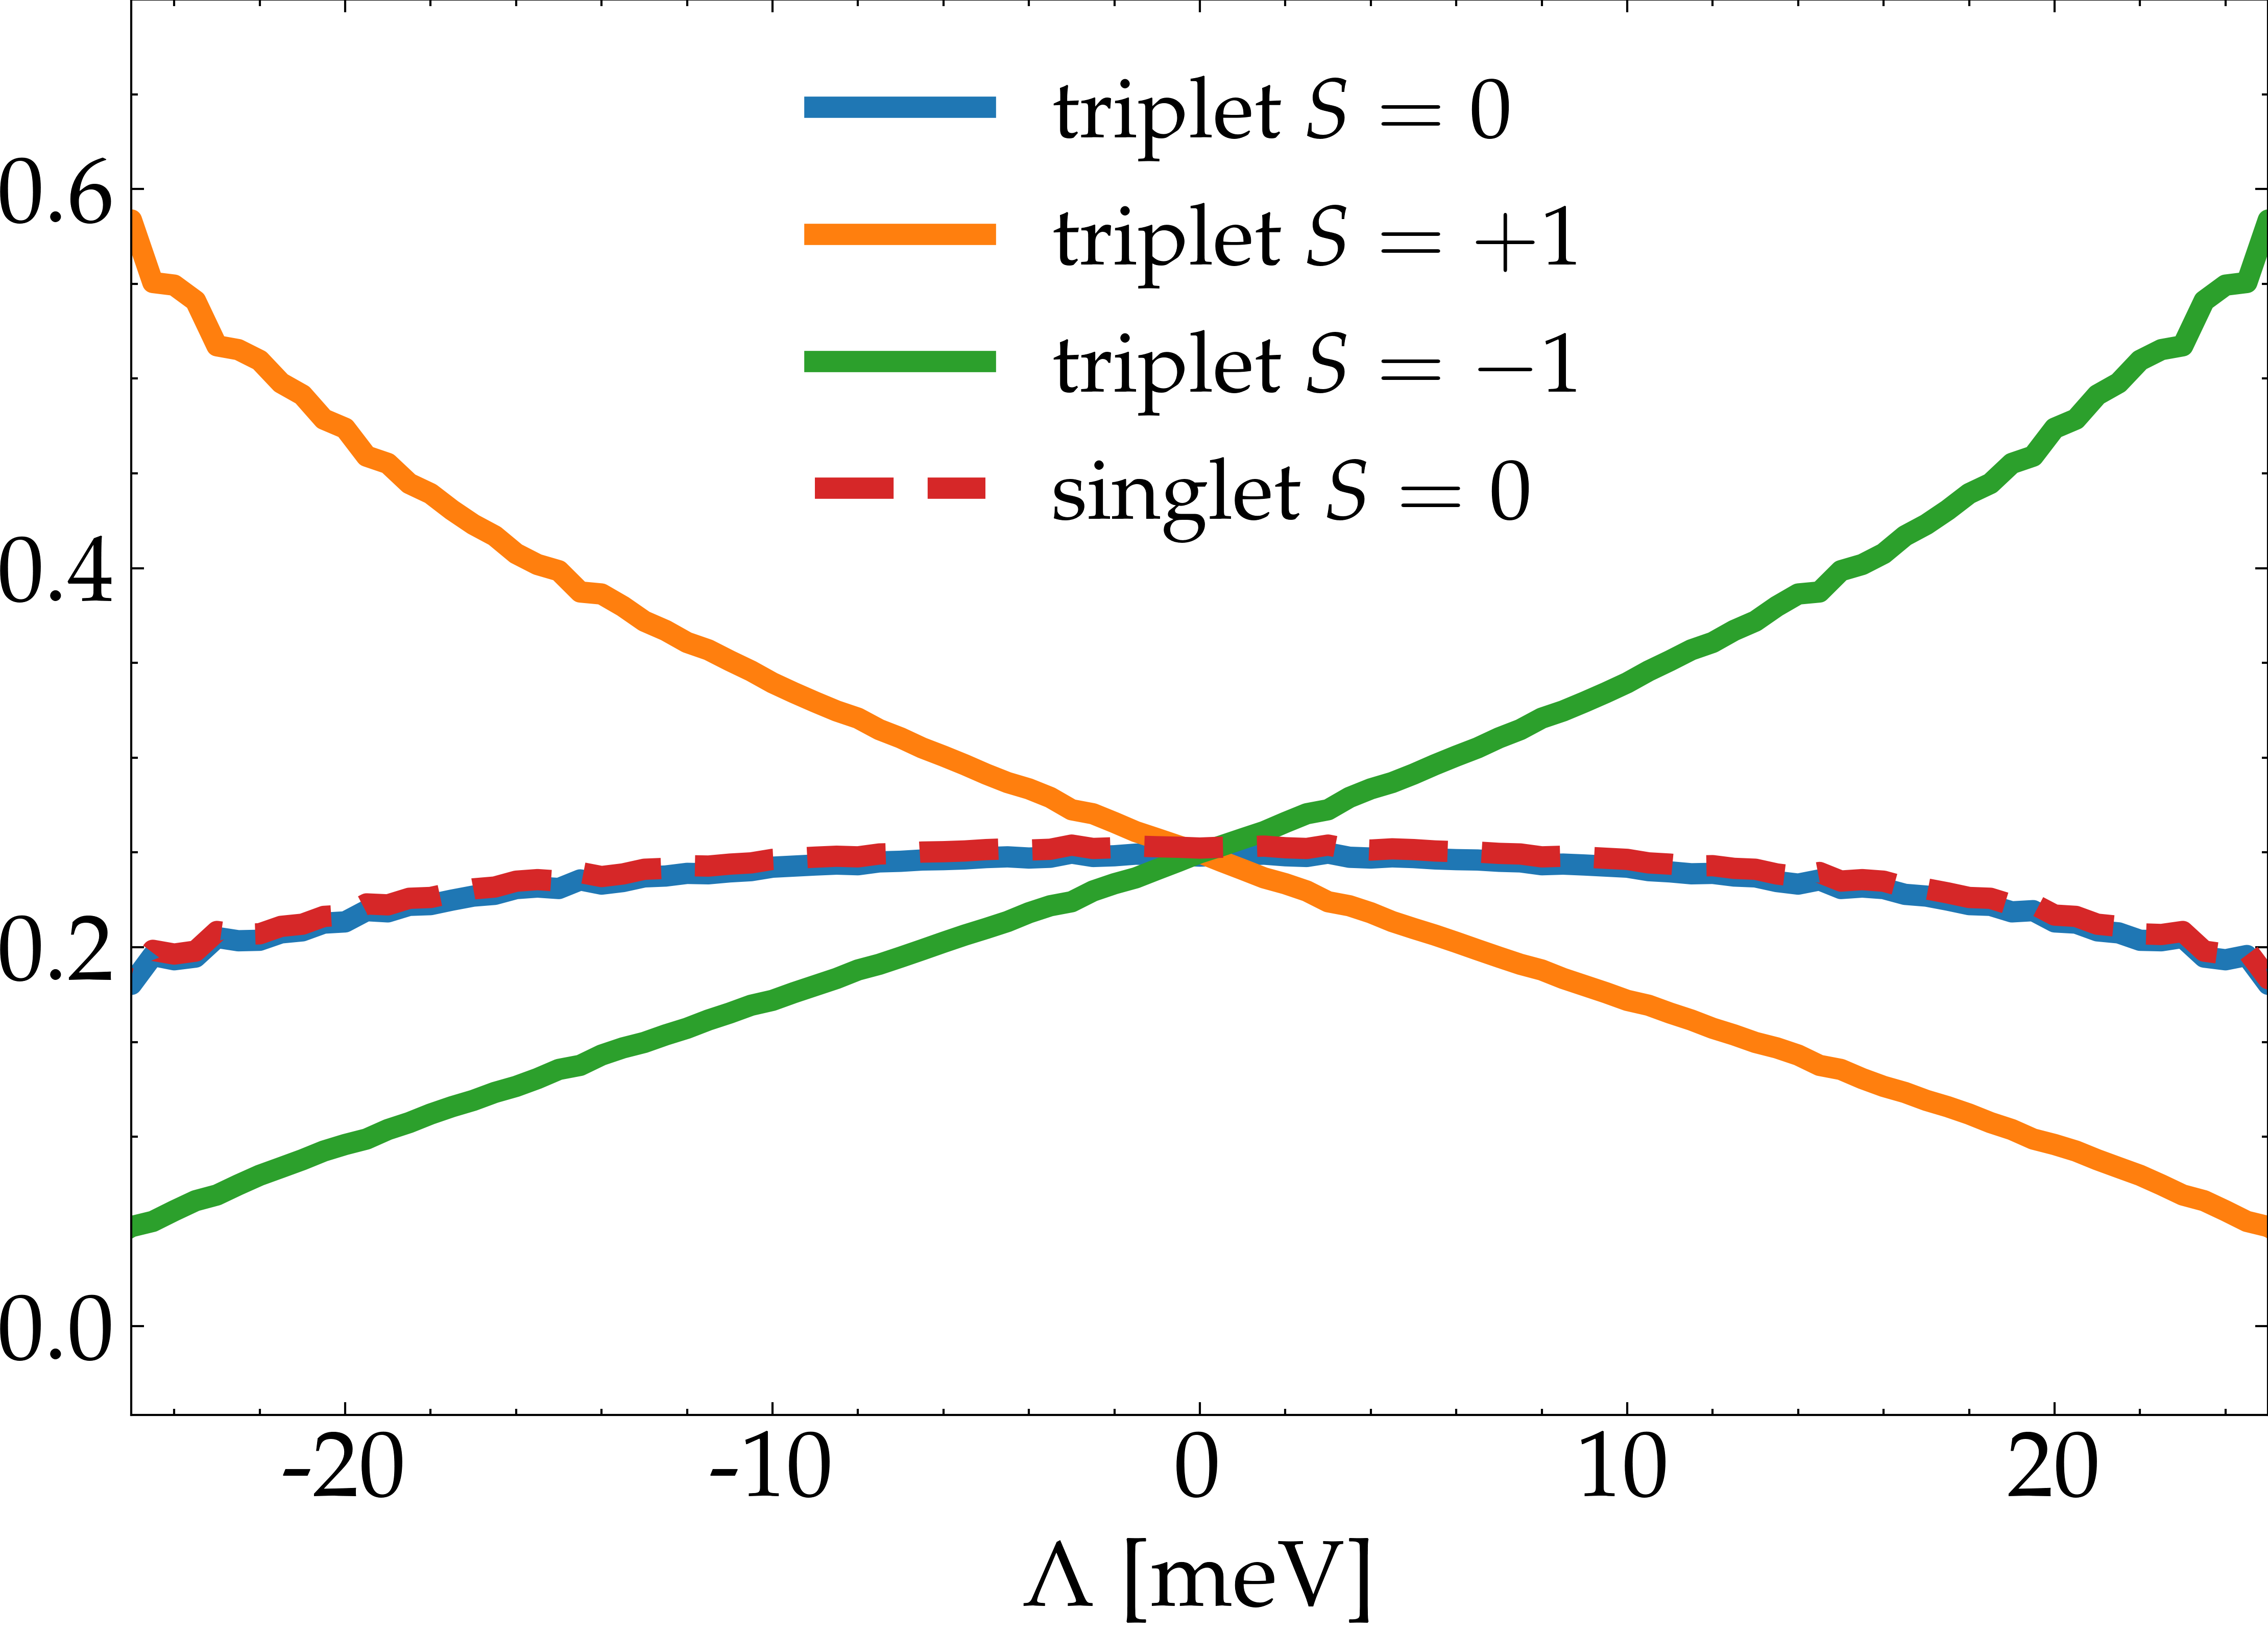

In [15]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

# normalization
norm = np.sum(ft_0+ft_p1+ft_m1+fs_0, axis=1)

# singlet component
fs_0_sum = np.sum(fs_0, axis=1)/norm
# triplet components
ft_0_sum = np.sum(ft_0, axis=1)/norm
ft_p1_sum = np.sum(ft_p1, axis=1)/norm
ft_m1_sum = np.sum(ft_m1, axis=1)/norm
# total sum
f_all = fs_0_sum + ft_0_sum + ft_p1_sum + ft_m1_sum


# plot triplet components
ax.plot(Zeeman, ft_0_sum, lw=5, label='triplet $S=0$')
ax.plot(Zeeman, ft_p1_sum, lw=5, label='triplet $S=+1$')
ax.plot(Zeeman, ft_m1_sum, lw=5, label='triplet $S=-1$')
# plot singlet component
ax.plot(Zeeman, fs_0_sum, lw=5, label='singlet $S=0$', ls='--')
# plot total sum
ax.plot(Zeeman, f_all, lw=2, c='black')

ax.set_xlim(-0.025, 0.025)
ax.set_ylim(ax.get_ylim()[0], 0.7)

ax.set_xlabel("$\Lambda$ [meV]", fontsize = 22)
ax.set_xticks([-0.020, -0.010, 0, 0.010, 0.020])
ax.set_xticklabels(['-20', '-10', '0', '10', '20'])


ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=20);

#fig.savefig("Paper/spin_components.pdf", bbox_inches='tight')